In [32]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pymc3 as pm
import arviz as az


In [17]:
theta_gt = [2, 5]
X = np.random.uniform(0, 1, 100)
Y = theta_gt[0] + theta_gt[1] * X + np.random.normal(0, 1, 100)

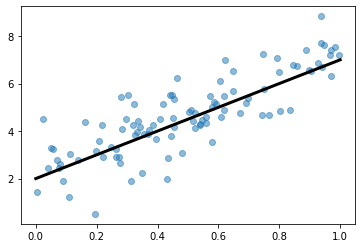

In [24]:
plt.scatter(X, Y, alpha=0.5)
x_line = np.linspace(0, 1, 1000)
y_line_gt = theta_gt[0] + theta_gt[1] * x_line
plt.plot(x_line, y_line_gt, color='k',lw=3)

In [63]:
basic_model = pm.Model()

with basic_model:

    # Priors for unknown model parameters
    theta = pm.Normal("theta", mu=0, sigma=10, shape=2)
    sigma = pm.HalfNormal("sigma", sigma=1)
    X_ = pm.Data('features', X)
    # Expected value of outcome
    mu = theta[0] + theta[1] * X_
    
    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal("Y_obs", mu=mu, sigma=sigma, observed=Y)

In [64]:
map_estimate = pm.find_MAP(model=basic_model)

In [65]:
map_estimate

{'theta': array([2.1821466 , 5.02074971]),
 'sigma_log__': array(-0.09116321),
 'sigma': array(0.91286871)}

In [66]:
with basic_model:
    # draw 500 posterior samples
    trace = pm.sample(2000,return_inferencedata=False,tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, theta]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 14 seconds.
The acceptance probability does not match the target. It is 0.8876949123102069, but should be close to 0.8. Try to increase the number of tuning steps.


/usr/local/anaconda3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa43840b9a0>,
      dtype=object)

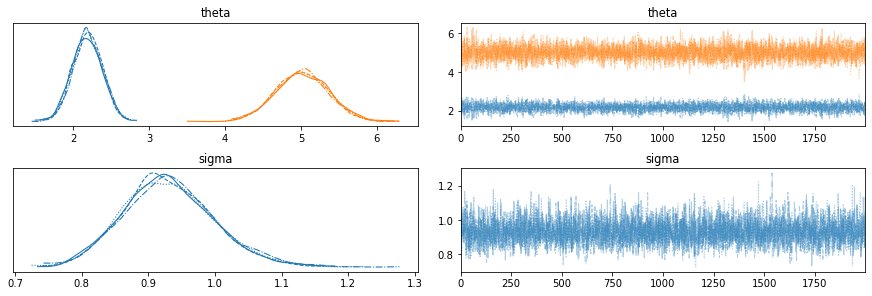

In [67]:
az.plot_trace(trace)

In [68]:
with basic_model:
    display(az.summary(trace, round_to=2))

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta[0],2.19,0.20,1.83,2.55,0.00,0.0,3536.33,3545.41,1.0
theta[1],5.02,0.35,4.37,5.67,0.01,0.0,3456.16,3666.80,1.0
sigma,0.93,0.07,0.80,1.06,0.00,0.0,3953.39,3593.95,1.0


In [100]:
x_new = np.linspace(-1, 1, 100) # 50 input values between -3 and 3
with basic_model:
    pm.set_data({'features': x_new})
    posterior = pm.sample_posterior_predictive(trace)

In [101]:
preds = posterior['Y_obs']

In [102]:
preds.shape

(8000, 100)

In [103]:
y_mean = np.mean(preds, axis=0)

In [104]:
y_std = np.std(preds, axis=0)

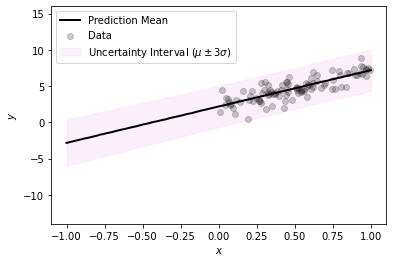

In [110]:
plt.scatter(X, Y, c='k', zorder=10, label='Data',alpha=0.2)
plt.plot(x_new, y_mean, label='Prediction Mean',color='black',lw=2)
plt.fill_between(x_new, y_mean - 3*y_std, y_mean + 3*y_std, alpha=0.12, label='Uncertainty Interval ($\mu\pm3\sigma$)',color='violet')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.ylim(-14, 16)
plt.legend(loc='upper left')


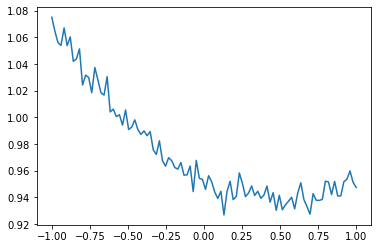

In [113]:
plt.plot(x_new, y_std)

## Laplacian Prior (LASSO)

In [154]:
class Lasso:
    def __init__(self, b):
        self.b = b
    
    def fit(self, X, y):
        lasso_model = pm.Model()
        self.model = lasso_model
        with self.model:

            # Priors for unknown model parameters
            theta = pm.Laplace("theta", mu=0, b=self.b, shape=2)
            sigma = pm.HalfNormal("sigma", sigma=1)
            X_ = pm.Data('features', X)
            # Expected value of outcome
            mu = theta[0] + theta[1] * X_

            # Likelihood (sampling distribution) of observations
            Y_obs = pm.Normal("Y_obs", mu=mu, sigma=sigma, observed=Y)
            trace_lasso = pm.sample(1500,return_inferencedata=False,tune=500)
        self.model = lasso_model
        self.trace = trace_lasso
        
    def plot(self):
        az.plot_trace(self.trace)
        
    def predict(self, X):
        with self.model:
            pm.set_data({'features': X})
            posterior = pm.sample_posterior_predictive(self.trace)
        self.posterior = posterior      

In [166]:
out = {}
regs = {}
for b in [0.02, 0.05, 0.07, 0.1, 0.2, 1]:
    reg = Lasso(b)
    reg.fit(X, Y)
    regs[b] = reg
    out[b] = reg.trace['theta']

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, theta]


Sampling 4 chains for 500 tune and 1_500 draw iterations (2_000 + 6_000 draws total) took 11 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, theta]


Sampling 4 chains for 500 tune and 1_500 draw iterations (2_000 + 6_000 draws total) took 11 seconds.
The acceptance probability does not match the target. It is 0.8950862393930992, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9001430434934337, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, theta]


Sampling 4 chains for 500 tune and 1_500 draw iterations (2_000 + 6_000 draws total) took 12 seconds.
The acceptance probability does not match the target. It is 0.8872049026216231, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8926119008971145, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, theta]


Sampling 4 chains for 500 tune and 1_500 draw iterations (2_000 + 6_000 draws total) took 11 seconds.
The acceptance probability does not match the target. It is 0.8957605161750353, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, theta]


Sampling 4 chains for 500 tune and 1_500 draw iterations (2_000 + 6_000 draws total) took 11 seconds.
The acceptance probability does not match the target. It is 0.9115157275409002, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8951962162827283, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, theta]


Sampling 4 chains for 500 tune and 1_500 draw iterations (2_000 + 6_000 draws total) took 11 seconds.
The acceptance probability does not match the target. It is 0.8839670790851839, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8965663402771328, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.891884956026622, but should be close to 0.8. Try to increase the number of tuning steps.


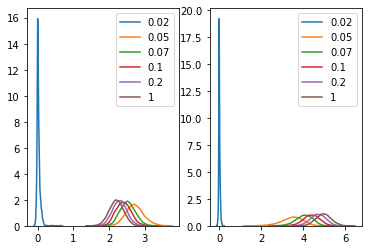

In [167]:
fig, ax = plt.subplots(ncols=2)
for i, b in enumerate([0.02, 0.05, 0.07, 0.1, 0.2, 1]):
    sns.kdeplot(out[b][:, 0], ax=ax[0], label=b)
    sns.kdeplot(out[b][:, 1], ax=ax[1], label=b)
plt.legend()

In [171]:
def plot_custom(b):
    reg = regs[b]
    reg.predict(x_new)
    preds = reg.posterior['Y_obs']
    y_mean = np.mean(preds, axis=0)
    y_std = np.std(preds, axis=0)
    plt.scatter(X, Y, c='k', zorder=10, label='Data',alpha=0.2)
    plt.plot(x_new, y_mean, label='Prediction Mean',color='black',lw=2)
    plt.fill_between(x_new, y_mean - 3*y_std, y_mean + 3*y_std, alpha=0.12, label='Uncertainty Interval ($\mu\pm3\sigma$)',color='violet')
    plt.xlabel('$x$')
    plt.ylabel('$y$')
    plt.ylim(-14, 16)
    plt.legend(loc='upper left')

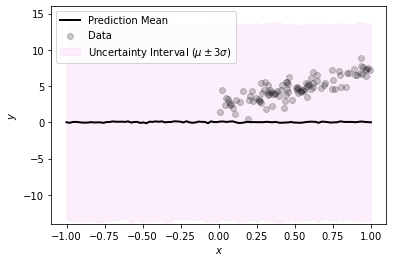

In [172]:
plot_custom(0.02)

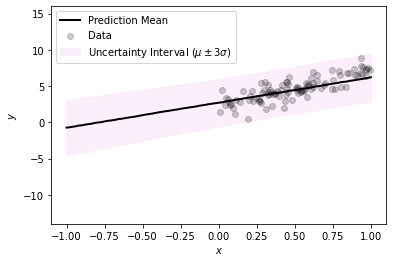

In [173]:
plot_custom(0.05)

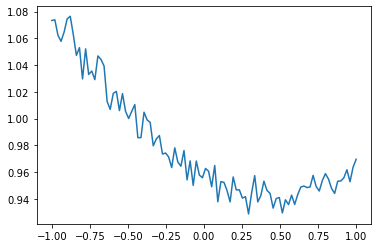

In [165]:
plot_custom(0.02)